## Prophet Model

https://nbviewer.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb

In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import prophet

In [2]:
input_file = "../data/processed/ep/merged_with_holidays.parquet"
train_split_indices_file = "../data/processed/splits/train_indices.parquet"
val_split_indices_file = "../data/processed/splits/validation_indices.parquet"

data_df = pd.read_parquet(input_file)
train_indices = pd.read_parquet(train_split_indices_file)
val_indices = pd.read_parquet(val_split_indices_file)

train_df = data_df.loc[train_indices["0"]]
val_df = data_df.loc[val_indices["0"]]

print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")

Training data shape: (10485477, 10)
Validation data shape: (1852375, 10)


In [3]:
# set wait times from January to March to 0
train_df.loc[
    (train_df["timestamp"].dt.month == 1)
    | (train_df["timestamp"].dt.month == 2)
    | (train_df["timestamp"].dt.month == 3),
    "wait_time",
] = 0

val_df .loc[
    (val_df["timestamp"].dt.month == 1)
    | (val_df["timestamp"].dt.month == 2)
    | (val_df["timestamp"].dt.month == 3),
    "wait_time",
] = 0

In [4]:
ride_names = data_df["ride_name"].unique()
print(ride_names)

['alpine express enzian' 'poppy towers' 'silver star' 'swiss bob run'
 'tirol log flume' 'vienna wave swing  glckspilz' 'voletarium' 'pegasus'
 'volo da vinci' 'whale adventures  northern lights' 'pirates in batavia'
 'snorri touren' 'voltron nevera powered by rimac' 'bellevue ferris wheel'
 'tnnevirvel' 'poseidon' 'old mac donalds tractor fun' 'vindjammer'
 'madame freudenreich curiosits' 'matterhornblitz' 'arthur'
 'atlantica supersplash' 'atlantis adventure' 'baaa express'
 'blue fire megacoaster' 'castello dei medici' 'dancing dingie'
 'arena of football  be part of it' 'eurotower' 'eurosat  cancan coaster'
 'fjordrafting' 'jim button  journey through morrowland'
 'josefinas magical imperial journey' 'kolumbusjolle' 'euromir']


In [5]:
ride_name = "silver star"
train_ride_df = train_df.loc[data_df["ride_name"] == ride_name]
val_ride_df = val_df.loc[data_df["ride_name"] == ride_name]

print(f"Train ride data shape: {train_ride_df.shape}")
print(f"Validation ride data shape: {val_ride_df.shape}")

Train ride data shape: (297105, 10)
Validation ride data shape: (52925, 10)


<Axes: xlabel='timestamp'>

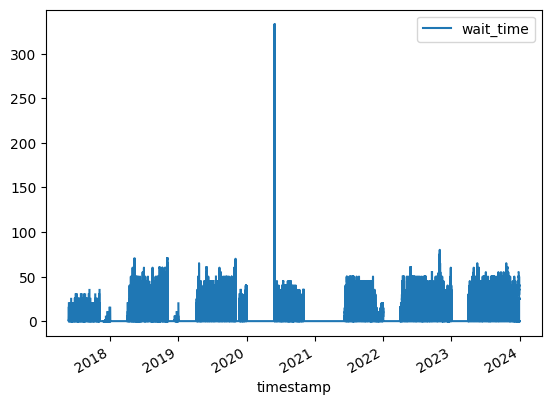

In [6]:
train_wait_times_df = train_ride_df[["timestamp", "wait_time"]]
val_wait_times_df = val_ride_df[["timestamp", "wait_time"]]

pd.concat([train_wait_times_df, val_wait_times_df]).plot(x="timestamp")

In [7]:
# Source: https://github.com/nicolasfauchereau/Auckland_Cycling/blob/master/code/utils.py
def median_filter(df, varname = None, window=24, std=3): 
    """
    A simple median filter, removes (i.e. replace by np.nan) observations that exceed N (default = 3) 
    tandard deviation from the median over window of length P (default = 24) centered around 
    each observation.

    Parameters
    ----------
    df : pandas.DataFrame
        The pandas.DataFrame containing the column to filter.
    varname : string
        Column to filter in the pandas.DataFrame. No default. 
    window : integer 
        Size of the window around each observation for the calculation 
        of the median and std. Default is 24 (time-steps).
    std : integer 
        Threshold for the number of std around the median to replace 
        by `np.nan`. Default is 3 (greater / less or equal).

    Returns
    -------
    dfc : pandas.Dataframe
        A copy of the pandas.DataFrame `df` with the new, filtered column `varname`
    """
    
    dfc = df.loc[:,[varname]]
    dfc['median']= dfc[varname].rolling(window, center=True).median()
    dfc['std'] = dfc[varname].rolling(window, center=True).std()
    dfc.loc[dfc.loc[:,varname] >= dfc['median']+std*dfc['std'], varname] = np.nan
    dfc.loc[dfc.loc[:,varname] <= dfc['median']-std*dfc['std'], varname] = np.nan
    
    return dfc.loc[:, varname]

In [8]:
train_wait_times_filtered_df = train_wait_times_df.copy()
val_wait_times_filtered_df = val_wait_times_df.copy()

# cap wait times to 90 minutes
train_wait_times_filtered_df.loc[train_wait_times_filtered_df["wait_time"] > 90, "wait_time"] = 90
val_wait_times_filtered_df.loc[val_wait_times_filtered_df["wait_time"] > 90, "wait_time"] = 90

# apply median filter
train_wait_times_filtered_df.loc[:, "wait_time_filtered"] = median_filter(train_wait_times_filtered_df, "wait_time")
val_wait_times_filtered_df.loc[:, "wait_time_filtered"] = median_filter(val_wait_times_filtered_df, "wait_time")

<Axes: xlabel='timestamp'>

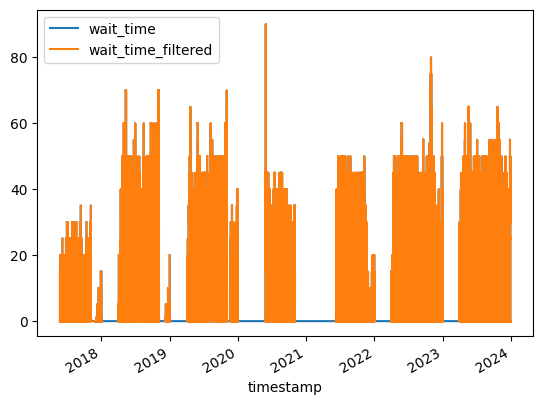

In [9]:
pd.concat([train_wait_times_filtered_df, val_wait_times_filtered_df]).plot(x="timestamp")

In [10]:
train_wait_times_filtered_df = train_wait_times_filtered_df.reset_index()
val_wait_times_filtered_df = val_wait_times_filtered_df.reset_index()

train_wait_times_filtered_df = train_wait_times_filtered_df.rename(columns={"timestamp": "ds", "wait_time_filtered": "y"})
val_wait_times_filtered_df = val_wait_times_filtered_df.rename(columns={"timestamp": "ds", "wait_time_filtered": "y"})

train_wait_times_filtered_df = train_wait_times_filtered_df.drop(columns=["index", "wait_time"])
val_wait_times_filtered_df = val_wait_times_filtered_df.drop(columns=["index", "wait_time"])

In [11]:
print(train_wait_times_filtered_df.head())
print(val_wait_times_filtered_df.head())

                   ds     y
0 2017-05-23 09:00:00   0.0
1 2017-05-23 09:05:00   NaN
2 2017-05-23 09:10:00   1.0
3 2017-05-23 09:15:00   NaN
4 2017-05-23 09:20:00  10.0
                   ds    y
0 2023-01-01 09:00:00  0.0
1 2023-01-01 09:05:00  0.0
2 2023-01-01 09:10:00  0.0
3 2023-01-01 09:15:00  0.0
4 2023-01-01 09:20:00  0.0


In [12]:
# create separate holidays df from the 'is_german_holiday', 'is_swiss_holiday', and 'is_french_holiday' columns
def create_holidays_df(data_df):
    swiss_holidays = train_ride_df.loc[
        train_ride_df["is_swiss_holiday"] == 1, ["timestamp"]
    ]
    swiss_holidays = swiss_holidays.rename(columns={"timestamp": "ds"})
    swiss_holidays["holiday"] = "swiss_holiday"
    swiss_holidays["lower_window"] = 0
    swiss_holidays["upper_window"] = 0
    swiss_holidays = swiss_holidays.reset_index()

    german_holidays = train_ride_df.loc[
        train_ride_df["is_german_holiday"] == 1, ["timestamp"]
    ]
    german_holidays = german_holidays.rename(columns={"timestamp": "ds"})
    german_holidays["holiday"] = "german_holiday"
    german_holidays["lower_window"] = 0
    german_holidays["upper_window"] = 0
    german_holidays = german_holidays.reset_index()

    french_holidays = train_ride_df.loc[
        train_ride_df["is_french_holiday"] == 1, ["timestamp"]
    ]
    french_holidays = french_holidays.rename(columns={"timestamp": "ds"})
    french_holidays["holiday"] = "french_holiday"
    french_holidays["lower_window"] = 0
    french_holidays["upper_window"] = 0
    french_holidays = french_holidays.reset_index()

    return swiss_holidays, german_holidays, french_holidays

train_swiss_holidays, train_german_holidays, train_french_holidays = create_holidays_df(train_ride_df)
val_swiss_holidays, val_german_holidays, val_french_holidays = create_holidays_df(val_ride_df)

In [13]:
# create df with covid lockdown dates
covid_lockdown_1_df = pd.DataFrame({
    'holiday': 'covid_lockdown_1',
    'ds': pd.date_range(start='2020-03-14', end='2020-05-29'),
    'lower_window': 0,
    'upper_window': 0
})

covid_lockdown_2_df = pd.DataFrame({
    'holiday': 'covid_lockdown_2',
    'ds': pd.date_range(start='2020-11-02', end='2021-05-20'),
    'lower_window': 0,
    'upper_window': 0
})

covid_recovery_df = pd.DataFrame({
    'holiday': 'covid_recovery',
    'ds': pd.date_range(start='2021-05-21', end='2021-07-31'),
    'lower_window': 0,
    'upper_window': 0
})

In [14]:
# define regular seasonal closures (Jan-Mar each year)
seasonal_closures = pd.DataFrame()
years = range(2017, 2024)  # All years in your dataset plus forecast year
for year in years:
    temp_df = pd.DataFrame({
        'holiday': 'seasonal_closure',
        'ds': pd.date_range(start=f'{year}-01-01', end=f'{year}-03-31')
    })
    seasonal_closures = pd.concat([seasonal_closures, temp_df])

In [15]:
all_holidays_df = pd.concat(
    [
        train_swiss_holidays,
        train_german_holidays,
        train_french_holidays,
        val_swiss_holidays,
        val_german_holidays,
        val_french_holidays,
        covid_lockdown_1_df,
        covid_lockdown_2_df,
        covid_recovery_df,
        seasonal_closures,
    ]
)
all_holidays_df = all_holidays_df.drop(columns=["index"])
all_holidays_df = all_holidays_df.reset_index(drop=True)

all_holidays_df

,ds,holiday,lower_window,upper_window
0,2017-05-25 09:00:00,swiss_holiday,0.0,0.0
1,2017-05-25 09:05:00,swiss_holiday,0.0,0.0
2,2017-05-25 09:10:00,swiss_holiday,0.0,0.0
3,2017-05-25 09:15:00,swiss_holiday,0.0,0.0
4,2017-05-25 09:20:00,swiss_holiday,0.0,0.0
...,...,...,...,...
63325,2023-03-27 00:00:00,seasonal_closure,NaN,NaN
63326,2023-03-28 00:00:00,seasonal_closure,NaN,NaN
63327,2023-03-29 00:00:00,seasonal_closure,NaN,NaN
63328,2023-03-30 00:00:00,seasonal_closure,NaN,NaN


In [16]:
model = prophet.Prophet(
    # Core parameters
    seasonality_mode='multiplicative',  # Better for tourism/attraction data
    changepoint_prior_scale=0.01,       # Flexibility in trend changes
    
    # Handling closures
    seasonality_prior_scale=10,         # Stronger seasonality influence
    yearly_seasonality=True,            # Capture yearly patterns
    weekly_seasonality=True,            # Capture weekly patterns
    daily_seasonality=20,               # Higher order for complex intraday patterns
    
    # Specific to park operation
    holidays_prior_scale=10,             # Strong holiday effects for parks,
    holidays=all_holidays_df,           # Include holidays and covid lockdowns
)

# Add sub-daily seasonality explicitly (important for 5-min data)
model.add_seasonality(
    name='intraday',
    period=1,  # 1 day
    fourier_order=20  # Higher order for capturing complex patterns within day
)

In [17]:
model.fit(train_wait_times_filtered_df)

20:06:04 - cmdstanpy - INFO - Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
future = model.make_future_dataframe(periods=val_wait_times_filtered_df.shape[0], freq="5min")
future.head()

,ds
0,2017-05-23 09:00:00
1,2017-05-23 09:05:00
2,2017-05-23 09:10:00
3,2017-05-23 09:15:00
4,2017-05-23 09:20:00


In [19]:
forecast = model.predict(future)

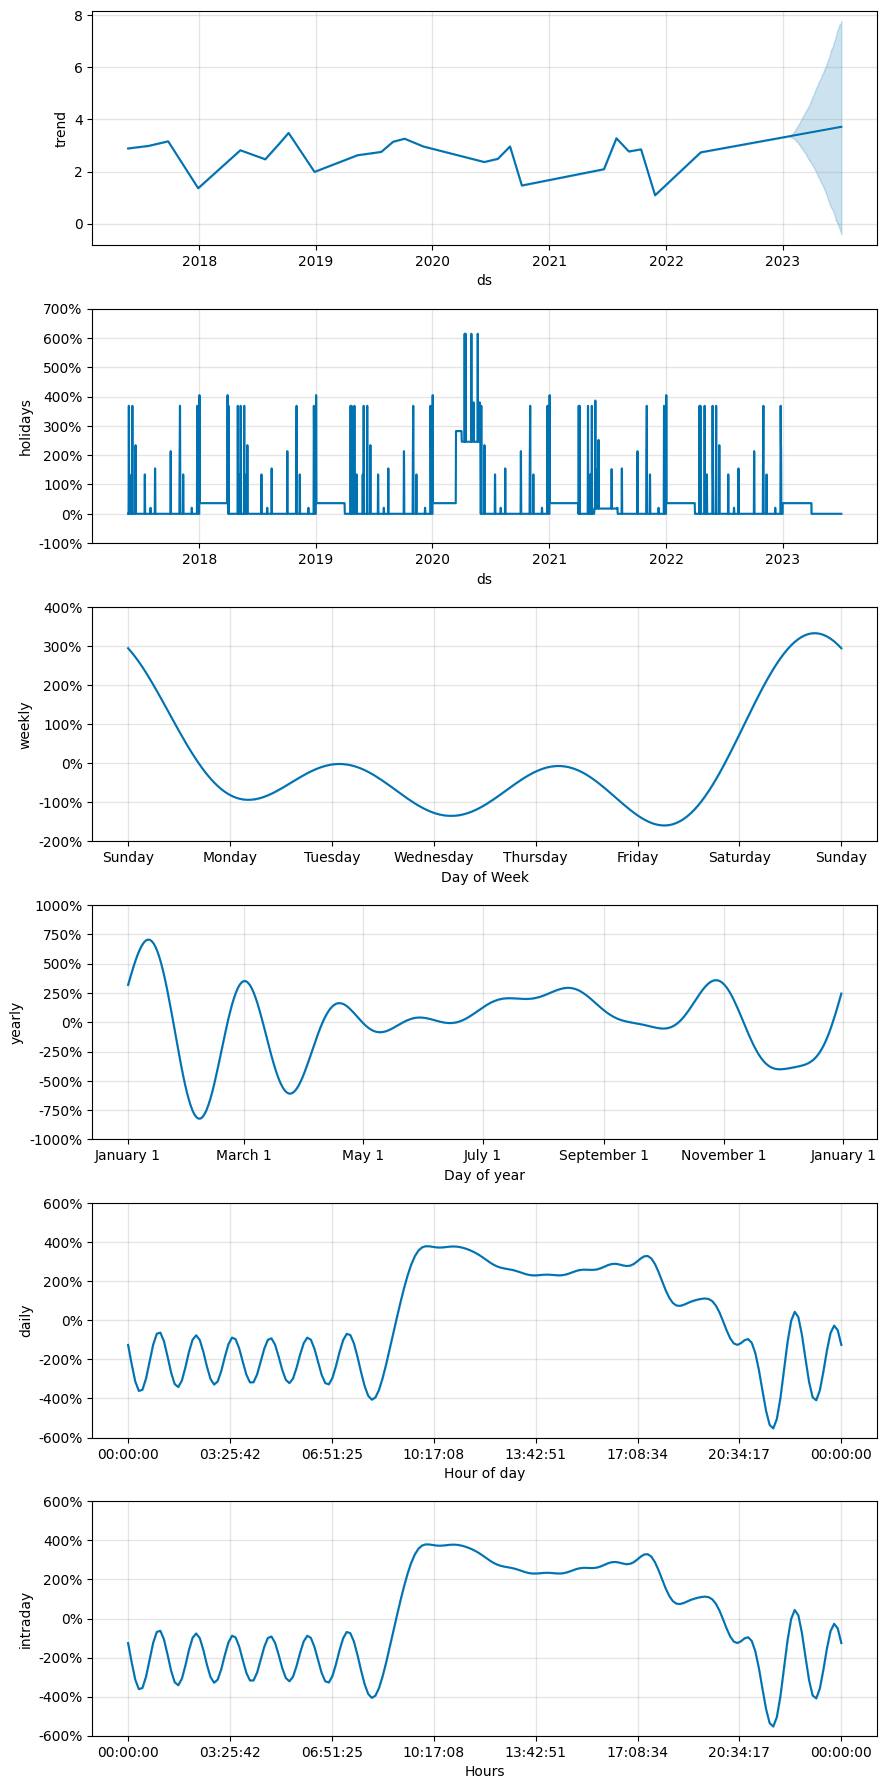

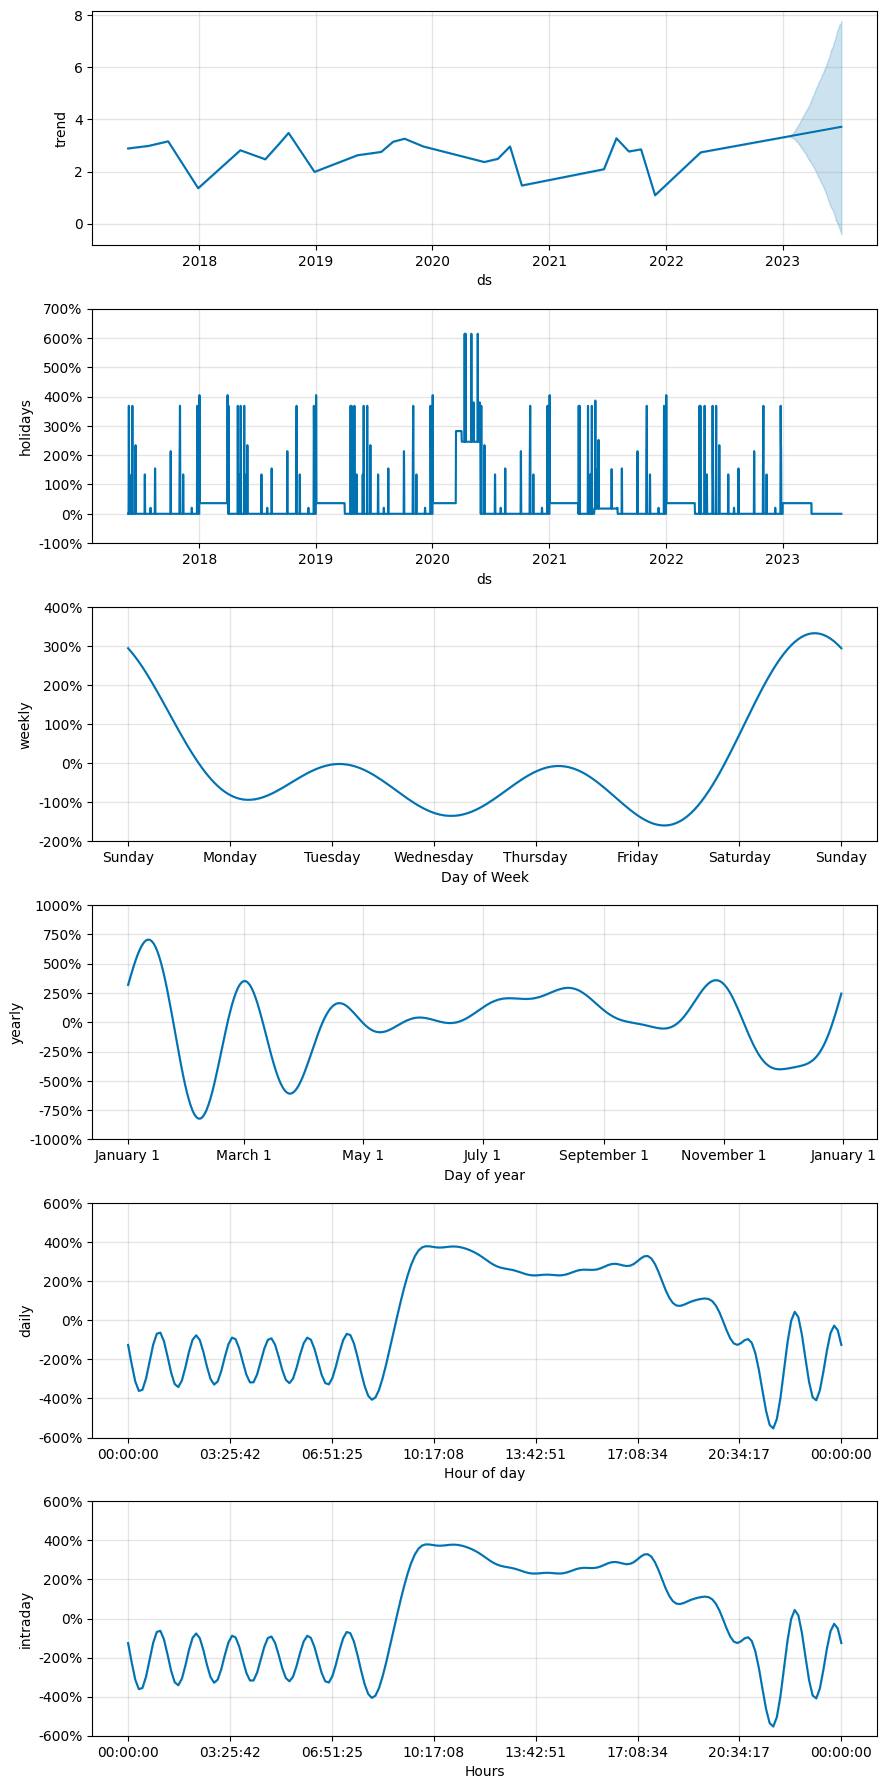

In [20]:
model.plot_components(forecast)

In [21]:
def make_verif(forecast, data_train, data_test): 
    """
    Put together the forecast (coming from fbprophet) 
    and the overved data, and set the index to be a proper datetime index, 
    for plotting

    Parameters
    ----------
    forecast : pandas.DataFrame 
        The pandas.DataFrame coming from the `forecast` method of a fbprophet 
        model. 
    
    data_train : pandas.DataFrame
        The training set, pandas.DataFrame

    data_test : pandas.DataFrame
        The training set, pandas.DataFrame
    
    Returns
    -------
    forecast : 
        The forecast DataFrane including the original observed data.

    """
    
    forecast.index = pd.to_datetime(forecast.ds)
    
    data_train.index = pd.to_datetime(data_train.ds)
    
    data_test.index = pd.to_datetime(data_test.ds)
    
    data = pd.concat([data_train, data_test], axis=0)
    
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [22]:
verif = make_verif(forecast, train_wait_times_filtered_df, val_wait_times_filtered_df)

In [18]:
def plot_verif(verif, year):
    """
    plots the forecasts and observed data, the `year` argument is used to visualise 
    the division between the training and test sets. 

    Parameters
    ----------
    verif : pandas.DataFrame
        The `verif` DataFrame coming from the `make_verif` function in this package

    year : integer
        The year used to separate the training and test set. Default 2017

    Returns
    -------
    f : matplotlib Figure object

    """
    
    f, ax = plt.subplots(figsize=(14, 8))
    
    train = verif.loc[:str(year - 1),:]
    
    ax.plot(train.index, train.y, 'ko', markersize=3)
    
    ax.plot(train.index, train.yhat, color='steelblue', lw=0.5)
    
    ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, color='steelblue', alpha=0.3)
    
    test = verif.loc[str(year):,:]
    
    ax.plot(test.index, test.y, 'ro', markersize=3)
    
    ax.plot(test.index, test.yhat, color='coral', lw=0.5)
    
    ax.fill_between(test.index, test.yhat_lower, test.yhat_upper, color='coral', alpha=0.3)
    
    ax.axvline(pd.Timestamp(f'{year}-01-01'), color='0.8', alpha=0.7)
    
    ax.grid(ls=':', lw=0.5)
    
    return f

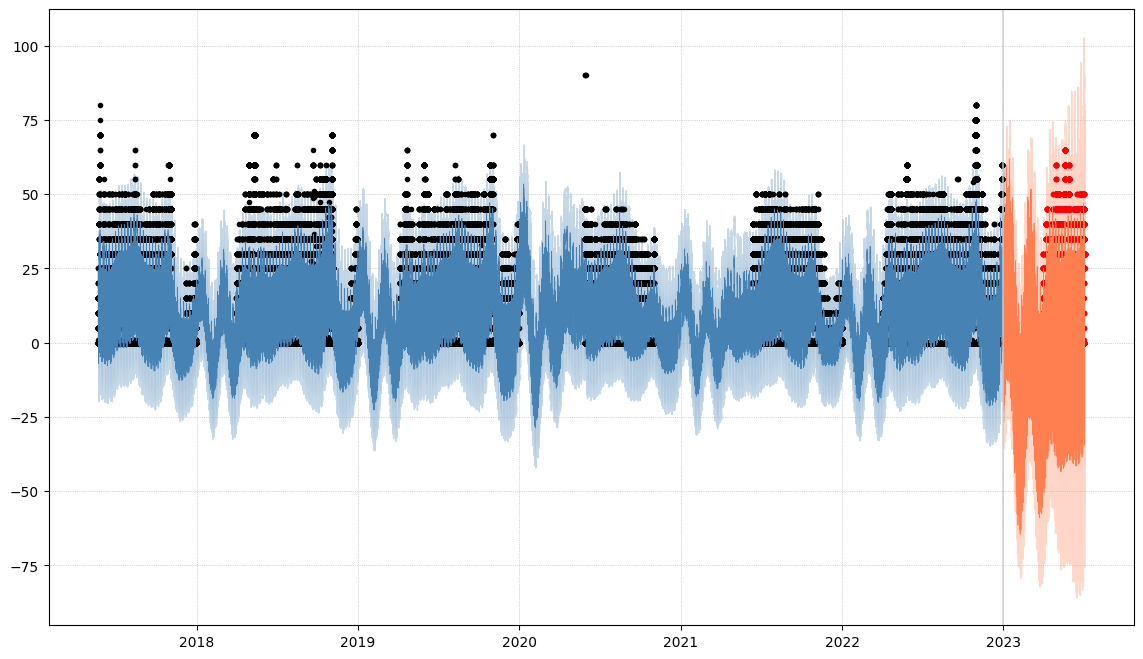

In [23]:
f = plot_verif(verif, year=2023)